# Generación Base de datos sin espectrograma
-----
En este notebook se realiza la generacion de la base de datos que será utilizada para el entrenamiento de los modelos de aprendizaje profundo desarrollados en el trabajo de grado titulado: "Clasificación de patologías cardiovasculares con máquinas de aprendizaje profundo a partir de señales ECG".

En este caso, se realiza la base de datos sin implementar la normalización.


## Importando las librerías necesarias para el código:

In [1]:
import numpy as np  # Calculos
import pandas as pd
from scipy import signal  # Para la implementación defiltros
from scipy.signal import filtfilt, butter, kaiserord, lfilter, firwin, resample_poly  # Filtros
from matplotlib import mlab
import matplotlib.pyplot as plt  # Para graficar señales
import wfdb  # Tratar BD MIT

## Definiendo funciones necesarias:


In [2]:
def FIRRemoveBL(ecgy, Fs, Fc, factor):
    
    """ Funcion que define el filtro FIR
    ecgy: la señal contaminada (debe ser una lista)
    Fc: frecuencia de corte
    Fs: frecuencia de muestreo
    ECG_Clean : señal procesada sin ruido de linea base"""
    
    # Se obtiene el tamaño de la señal de entrada
    signal_len = len(ecgy)
    
    # La frecuencia de Nyquist de la señal.
    nyq_rate = Fs / 2.0
    
    # El ancho deseado de la transición de stop a pass,relativo a la tasa de Nyquist.
    width = 0.07/nyq_rate 
    
    # Atenuación en la stopband del filtro, en dB.
    # relacionado con desarrolladores en Matlab. En Matlab está en proporción
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    
    # Calcula el orden y el parámetro Kaiser para el filtro FIR.
    N, beta = kaiserord(ripple_db, width)
       
    # Uso de la funcion firwin con una ventana Kaiser para crear un filtro FIR de paso alto.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Comprobar la condición del filtro
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtrando con filtfilt
        # Esta función aplica un filtro digital lineal dos veces, una hacia adelante y otra hacia atrás. 
        # El filtro combinado tiene fase cero y un orden de filtrado el doble que el original.
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        # Filtrando con filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
    
    return ECG_Clean, N
def rangos_ventaneo_senal(fs,tam_seg,rango):
    """Esta funcion es para generar los rangos de las ventanas de la señal a ventanear"""
    #Calculo el tamaño de la ventana 
    ventana=tam_seg*fs
    
    #Calculo los numeros iniciales de cada rango de ventanas, en este caso el paso será de la mitad del tamaño de la ventana, porque haremos un solapamiento del 50%
    ini_ran_ventanas=np.arange(rango[0],rango[1]-int(ventana/2),int(ventana/2))
    
    #Genero un arreglo con numeros de 0 hasta el tamaño de la ventana
    idx=np.arange(0,ventana)
    
    #Genero un vector columna donde cada numero representa el inicio de cada ventana que será aplicada a la señal
    inicios_ventana_vectorcolumna=ini_ran_ventanas[:,np.newaxis]
    
    #Sumo cada uno de los inicios anteriores, a un vector que va desde 0 a hasta el tamaño maximo de la ventana para generar los rangos necesarios
    ran_ventaneo=inicios_ventana_vectorcolumna+idx[np.newaxis,:]
    #Verifico si las ventanas están dentro del rango
    if ran_ventaneo[-1][-1]>rango[1]:
         ran_ventaneo=np.delete(ran_ventaneo,-1,axis=0)
    return  ran_ventaneo
def graph_spectrogram(ecg,fs):
    """Esta función extrae la matriz de datos del espectrograma de la señal"""
    
    nfft = 100 # Length of each window segment
    noverlap = 90 # Overlap between windows
    nchannels = ecg.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(ecg, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(ecg[:,0], nfft, fs, noverlap = noverlap)
    return pxx
def funcion_filtro_normalizacion_FA(paciente,data_path,Fs,resample=False):
    """Esta funcion se usa para aplicar los filtros y normalizar las señal del ECG"""
    # Parameters
    Fc = 0.67 # Recomendada en la bibliografia
    factor = 2
    
    #Extracción de las dos señales 
    grabacion=wfdb.rdrecord(data_path+paciente)
    senal_ecg_original=grabacion.p_signal
    #Extrayendo los dos canales de la señal
    senal_ecg_canal_I=senal_ecg_original[:,0].reshape(-1)
    senal_ecg_canal_II=senal_ecg_original[:,1].reshape(-1)

    #Filtrado de eliminación de línea base de la señal ECG
    senal_ecg_filtrada_FIR_I,N=FIRRemoveBL(senal_ecg_canal_I,Fs,Fc,factor) #implementación filtro FIR
    senal_ecg_filtrada_FIR_II,N=FIRRemoveBL(senal_ecg_canal_II,Fs,Fc,factor) #implementación filtro FIR

    # Implementación del filtro notch en los dos canales
    notch_freq= 60 # Hz
    quality_factor=20.0
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, Fs)
    senal_ecg_I_filtrada_notch = signal.filtfilt(b_notch, a_notch, senal_ecg_filtrada_FIR_I)
    senal_ecg_II_filtrada_notch = signal.filtfilt(b_notch, a_notch, senal_ecg_filtrada_FIR_II)
    
    if (resample): 
        senal_ecg_I_filtrada_notch=resample_poly(senal_ecg_I_filtrada_notch,25,36)
        senal_ecg_II_filtrada_notch=resample_poly(senal_ecg_II_filtrada_notch,25,36)
    
    return senal_ecg_I_filtrada_notch,senal_ecg_II_filtrada_notch 

## ECG Normal:
Se realiza la extración de la señal ECG de los pacientes de la base de datos MIT-BIH Arrhythmia Database, se realiza su filtrado, normalizado, ventaneado y se genera la matriz de 3 dimensiones de espectrogramas.

### Base de entrenamiento

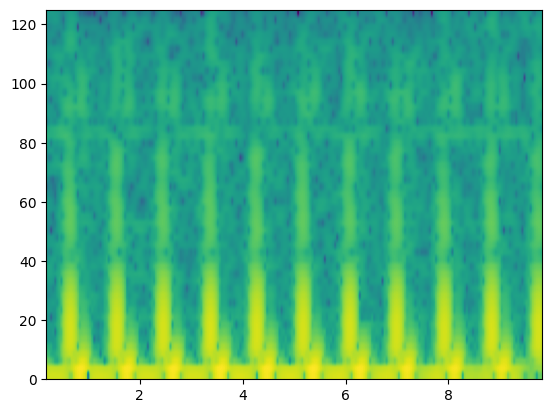

In [3]:
data_path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BaseDeDatos\\european-st-t-database-1.0.0\\'
FsBaseDatosOriginal = 250 # Frecuencia de muestreo
Fc = 0.67 # Recomendada en la bibliografia
factor = 2 # Recomendada en la bibliografia
tamano_ventana=10 # en segundos

lista_pacientes_Normal=np.array(['e0119','e0121','e0121','e0122','e0123','e0211','e0127','e0129'])
inicio_rangos=np.array([7,76,1140118,41,53,12,98,100])
final_rangos=np.array([89940,450096,1251439,579780,984479,229328,696113,403466])
#primer paciente
senal_ecg_canal_I_Normal,senal_ecg_canal_II_Normal=funcion_filtro_normalizacion_FA(lista_pacientes_Normal[0],data_path,FsBaseDatosOriginal,False)

senal_ecg_ventaneada_canal_I_Normal=senal_ecg_canal_I_Normal[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[int(inicio_rangos[0]),int(final_rangos[0])])]
senal_ecg_ventaneada_canal_II_Normal=senal_ecg_canal_II_Normal[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[int(inicio_rangos[0]),int(final_rangos[0])])]

pxx_all_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[0],FsBaseDatosOriginal)
pxx_all_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[0],FsBaseDatosOriginal)

#Segundo paciente
pxx_all_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[1],FsBaseDatosOriginal)
pxx_all_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[1],FsBaseDatosOriginal)

pxx_all_I=np.array([pxx_all_I_0,pxx_all_I_1])
pxx_all_II=np.array([pxx_all_II_0,pxx_all_II_1])

for i in np.arange(2,len(senal_ecg_ventaneada_canal_I_Normal)):
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[i],FsBaseDatosOriginal)
    pxx_all_I=np.insert(pxx_all_I,i,pxx,axis=0)
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[i],FsBaseDatosOriginal)
    pxx_all_II=np.insert(pxx_all_II,i,pxx,axis=0)
    
#Todos los demás pacientes
for i in np.arange(1,len(lista_pacientes_Normal)):
    #Extracción y filtrado de la señal
    senal_ecg_canal_I_Normal,senal_ecg_canal_II_Normal=funcion_filtro_normalizacion_FA(lista_pacientes_Normal[i],data_path,FsBaseDatosOriginal,True)
    
    #Ventaneo de la señal dando los parametros de frecuencia, tamaño de la ventana(en segundos), y rango de valores donde está la patología de interés
    senal_ecg_ventaneada_canal_I_Normal=senal_ecg_canal_I_Normal[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[0,len(senal_ecg_canal_I_Normal)])]
    senal_ecg_ventaneada_canal_II_Normal=senal_ecg_canal_II_Normal[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[0,len(senal_ecg_canal_II_Normal)])]
    
    #Generación de la matriz de datos del espectrograma
    #primera ventana
    pxx_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[0],FsBaseDatosOriginal)
    pxx_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[0],FsBaseDatosOriginal)
    #segunda ventana
    pxx_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[1],FsBaseDatosOriginal)
    pxx_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[1],FsBaseDatosOriginal)
    
    #Las demás ventanas
    pxx_I=np.array([pxx_I_0,pxx_I_1])
    pxx_II=np.array([pxx_II_0,pxx_II_1])
    for j in np.arange(2,len(senal_ecg_ventaneada_canal_I_Normal)):
        pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[j],FsBaseDatosOriginal)
        pxx_I=np.insert(pxx_I,j,pxx,axis=0)
        pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[j],FsBaseDatosOriginal)
        pxx_II=np.insert(pxx_II,j,pxx,axis=0)
    
    #Anexando matriz generada a pxx_1
    pxx_all_I=np.insert(pxx_all_I,len(pxx_all_I),pxx_I,axis=0)
    pxx_all_II=np.insert(pxx_all_II,len(pxx_all_II),pxx_II,axis=0)

In [4]:
pxx_all_Normal=np.array([pxx_all_I,pxx_all_II],dtype='float64')
print(pxx_all_Normal.shape)

(2, 7063, 51, 241)


In [5]:
ruta="C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_Normal\\"

pxx_all_Normal=np.moveaxis(pxx_all_Normal,0,-1)
print(pxx_all_Normal.shape)

#Guardando matriz original
np.save(ruta+'ECG_Normal_Original.npy',pxx_all_Normal)
print(pxx_all_Normal.shape)

# #Guardando matriz original reducida
# pxx_all_Normal_bd=pxx_all_Normal[:900,:,:,:]
# np.save(ruta+'ECG_Normal_Original_Red.npy',pxx_all_Normal_bd)
# print(pxx_all_Normal_bd.shape)

(7063, 51, 241, 2)
(7063, 51, 241, 2)


### Base de test

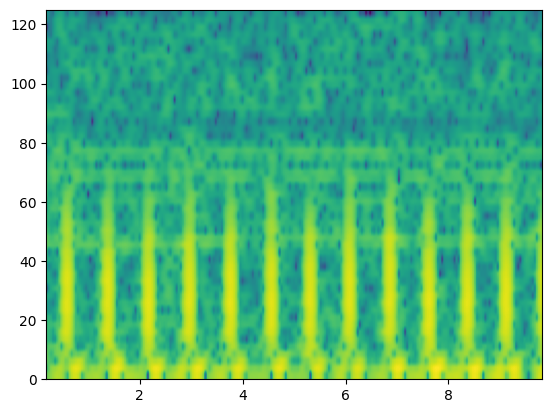

In [6]:
#Parametros
data_path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BaseDeDatos\\european-st-t-database-1.0.0\\'
FsBaseDatosOriginal = 250 # Frecuencia de muestreo
Fc = 0.67 # Recomendada en la bibliografia
factor = 2 # Recomendada en la bibliografia
tamano_ventana=10 # en segundos

lista_pacientes_Normal=np.array(['e0103','e0103','e0104','e0105','e0107','e0108'])
inicio_rangos=np.array([15,1626632,15,58,35,225])
final_rangos=np.array([214718,1702272,200014,60110,176057,399278])
#primer paciente
senal_ecg_canal_I_Normal,senal_ecg_canal_II_Normal=funcion_filtro_normalizacion_FA(lista_pacientes_Normal[0],data_path,FsBaseDatosOriginal,False)

senal_ecg_ventaneada_canal_I_Normal=senal_ecg_canal_I_Normal[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[int(inicio_rangos[0]),int(final_rangos[0])])]
senal_ecg_ventaneada_canal_II_Normal=senal_ecg_canal_II_Normal[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[int(inicio_rangos[0]),int(final_rangos[0])])]

pxx_all_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[0],FsBaseDatosOriginal)
pxx_all_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[0],FsBaseDatosOriginal)

#Segundo paciente
pxx_all_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[1],FsBaseDatosOriginal)
pxx_all_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[1],FsBaseDatosOriginal)

pxx_all_I=np.array([pxx_all_I_0,pxx_all_I_1])
pxx_all_II=np.array([pxx_all_II_0,pxx_all_II_1])

for i in np.arange(2,len(senal_ecg_ventaneada_canal_I_Normal)):
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[i],FsBaseDatosOriginal)
    pxx_all_I=np.insert(pxx_all_I,i,pxx,axis=0)
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[i],FsBaseDatosOriginal)
    pxx_all_II=np.insert(pxx_all_II,i,pxx,axis=0)
    
#Todos los demás pacientes
for i in np.arange(1,len(lista_pacientes_Normal)):
    #Extracción y filtrado de la señal
    senal_ecg_canal_I_Normal,senal_ecg_canal_II_Normal=funcion_filtro_normalizacion_FA(lista_pacientes_Normal[i],data_path,FsBaseDatosOriginal,True)
    
    #Ventaneo de la señal dando los parametros de frecuencia, tamaño de la ventana(en segundos), y rango de valores donde está la patología de interés
    senal_ecg_ventaneada_canal_I_Normal=senal_ecg_canal_I_Normal[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[0,len(senal_ecg_canal_I_Normal)])]
    senal_ecg_ventaneada_canal_II_Normal=senal_ecg_canal_II_Normal[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[0,len(senal_ecg_canal_II_Normal)])]
    
    #Generación de la matriz de datos del espectrograma
    #primera ventana
    pxx_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[0],FsBaseDatosOriginal)
    pxx_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[0],FsBaseDatosOriginal)
    #segunda ventana
    pxx_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[1],FsBaseDatosOriginal)
    pxx_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[1],FsBaseDatosOriginal)
    
    #Las demás ventanas
    pxx_I=np.array([pxx_I_0,pxx_I_1])
    pxx_II=np.array([pxx_II_0,pxx_II_1])
    for j in np.arange(2,len(senal_ecg_ventaneada_canal_I_Normal)):
        pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[j],FsBaseDatosOriginal)
        pxx_I=np.insert(pxx_I,j,pxx,axis=0)
        pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_Normal[j],FsBaseDatosOriginal)
        pxx_II=np.insert(pxx_II,j,pxx,axis=0)
    
    #Anexando matriz generada a pxx_1
    pxx_all_I=np.insert(pxx_all_I,len(pxx_all_I),pxx_I,axis=0)
    pxx_all_II=np.insert(pxx_all_II,len(pxx_all_II),pxx_II,axis=0)

In [7]:
pxx_all_Normal=np.array([pxx_all_I,pxx_all_II],dtype='float64')
print(pxx_all_Normal.shape)

ruta="C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_Normal\\"
pxx_all_Normal=np.moveaxis(pxx_all_Normal,0,-1)
print(pxx_all_Normal.shape)

#Guardando matriz test
pxx_all_Normal_bd=pxx_all_Normal[:,:,:,:]
np.save(ruta+'ECG_Normal_test.npy',pxx_all_Normal_bd)
print(pxx_all_Normal_bd.shape)

(2, 5165, 51, 241)
(5165, 51, 241, 2)
(5165, 51, 241, 2)


## Bradicardia:
Se realiza la extración de la señal ECG del paciente 232 de la base de datos MIT-BIH Arrhythmia Database, se realiza su filtrado, normalizado, ventaneado y se genera la matriz de 3 dimensiones de espectrogramas.

### Base de datos entrenamiento

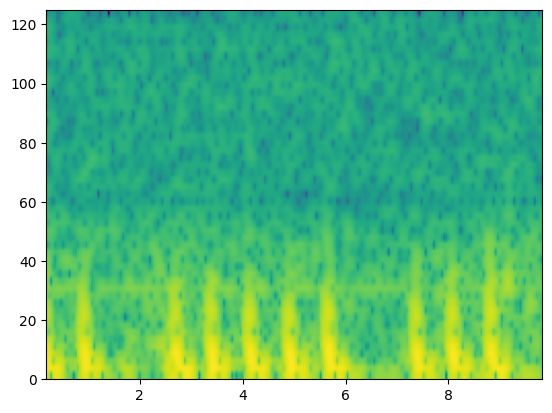

In [8]:
#Parametros
data_path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BaseDeDatos\\mit_bih_arrhythmiadatabase\\'
FsBaseDatosOriginal = 360 # Frecuencia de muestreo
FsBaseDatosTratada = 250 # Frecuencia de muestreo
Fc = 0.67 # Recomendada en la bibliografia
factor = 2 # Recomendada en la bibliografia
tamano_ventana=10
#Extracción y filtrado de la señal
senal_ecg_canal_I_SBR,senal_ecg_canal_II_SBR=funcion_filtro_normalizacion_FA('232',data_path,FsBaseDatosOriginal,True)

#Ventaneo de la señal dando los parametros de frecuencia, tamaño de la ventana(en segundos), y rango de valores donde está la patología de interés
senal_ecg_ventaneada_canal_I_SBR=senal_ecg_canal_I_SBR[rangos_ventaneo_senal(FsBaseDatosTratada,tamano_ventana,[0,len(senal_ecg_canal_I_SBR)])]
senal_ecg_ventaneada_canal_II_SBR=senal_ecg_canal_II_SBR[rangos_ventaneo_senal(FsBaseDatosTratada,tamano_ventana,[0,len(senal_ecg_canal_II_SBR)])]

#Generación de la matriz de matrices de espectrogramas
#Se extrae el primer espectograma y luego los espectogramas restantes se añaden a la matriz

#Primera Ventana
pxx_all_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_SBR[0],FsBaseDatosTratada)
pxx_all_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_SBR[0],FsBaseDatosTratada)

#Segunda ventana
pxx_all_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_SBR[1],FsBaseDatosTratada)
pxx_all_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_SBR[1],FsBaseDatosTratada)

pxx_all_I=np.array([pxx_all_I_0,pxx_all_I_1])
pxx_all_II=np.array([pxx_all_II_0,pxx_all_II_1])

#Ciclo para acabar de crear la matriz completa
for i in np.arange(2,len(senal_ecg_ventaneada_canal_I_SBR)):
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_SBR[i],FsBaseDatosTratada)
    pxx_all_I=np.insert(pxx_all_I,i,pxx,axis=0)
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_SBR[i],FsBaseDatosTratada)
    pxx_all_II=np.insert(pxx_all_II,i,pxx,axis=0)
# comprobación de tamaño


In [9]:
#Generación del array completo
pxx_all_SBR=np.array([pxx_all_I,pxx_all_II],dtype='float64')
print(pxx_all_SBR.shape)

(2, 360, 51, 241)


In [10]:
ruta="C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_Bradicardia\\"
pxx_all_SBR=np.moveaxis(pxx_all_SBR,0,-1)
print(pxx_all_SBR.shape)
#Guardando matriz original
np.save(ruta+'ECG_Bradicardia_Original.npy',pxx_all_SBR)
print(pxx_all_SBR.shape)

#Guardando matriz original reducida
# pxx_all_SBR_bd=pxx_all_SBR[:900,:,:,:]
# np.save(ruta+'ECG_Bradicardia_Original_Red.npy',pxx_all_SBR_bd)
# print(pxx_all_SBR_bd.shape)

(360, 51, 241, 2)
(360, 51, 241, 2)


## Fibrilación Auricular:
Se realiza la extración de la señal ECG de los pacientes que presentaban fibrilación auricular en la base de datos MIT-BIH Arrhythmia Database, y se realiza su filtrado, normalizado, ventaneado y se genera la matriz de 4 dimensiones de espectrogramas de dos canales.

In [11]:
# Extracción de símbolos para ver la ubicación de los segmentos de relevancia
# data_path='C:\\Users\\jdani\\Desktop\\Escritorio\\Universidad\\Trabajo de grado\\BaseDeDatos\\mit_bih_arrhythmiadatabase\\'
# lista_pacientes=['201','202','203','210','217','219','221','222']
# for i in lista_pacientes:
#     grabacion_fibrilacion_auricular=wfdb.rdrecord(data_path+i)
#     anotacion_fibrilacion_auricular=wfdb.rdann(data_path+i, 'atr')
#     datos=pd.DataFrame({'Simbolo':anotacion_fibrilacion_auricular.symbol,
#                         'Nota_Aux':anotacion_fibrilacion_auricular.aux_note,
#                         'Muestra':anotacion_fibrilacion_auricular.sample})
#     pd.DataFrame(datos).to_csv("C:\\Users\\jdani\\Desktop\\Prueba\\FibrilacionAuricularPaciente_"+i+".csv")
# datos

### Base de datos entrenamiento

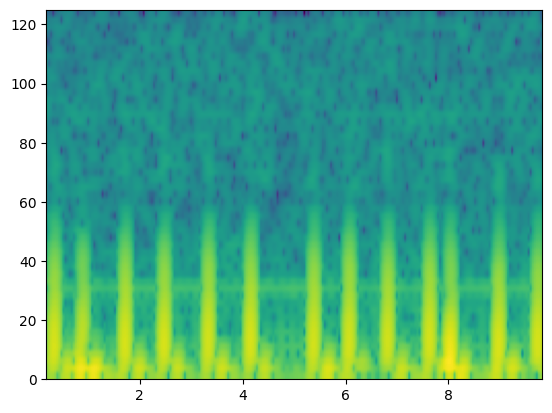

In [12]:
#Parámetros y listas necesarias
data_path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BaseDeDatos\\mit_bih_arrhythmiadatabase\\'
FsBaseDatosOriginal = 360 # Frecuencia de muestreo
FsBaseDatosTratada = 250 # Frecuencia de muestreo
FactorDeRemuestreo=25/36 #Factor por el que se multiplica para encontrar la parte de la señal equivalente despues del remuestreo
Fc = 0.67 # Recomendada en la bibliografia
factor = 2 # Recomendada en la bibliografia
tamano_ventana=10 # en segundos

lista_pacientes=np.array(['221','221','221','221','221','221','221','221','221','221','221','221',
                 '202','202','202','202',
                 '203','203','203','203','203','203','203','203','203','203','203','203','203','203','203','203','203','203','203','203','203',
                 '210','210','210','210','210','210','210','210','210',
                 '217','217','217','217','217','217','217','217','217','217','217','217','217','217','217','217','217','217','217','217','217','217','217','217',
                 '219','219','219','219','219','219','219','219','219','219'])
inicio_rangos=np.array([28,105889,146218,198216,249463,255055,262903,274162,283150,303654,350701,366521,
               411338,423479,468678,567041,
               14,17156,33602,38291,97315,109079,110710,184354,231406,241610,256022,267422,387405,405731,413805,415623,433425,539292,578810,590265,611153,
               13,152488,218539,367320,370012,390958,394037,400544,598041,
               67227,94358,157556,165653,171505,284647,290618,298753,301963,307295,316518,326545,332903,342271,347566,350868,370854,378125,380915,391074,392818,431944,457931,483993,
               188,36627,117599,307174,326615,339349,377625,401723,439101,501948])
final_rangos=np.array([103971,144439,196434,247715,253306,261160,272976,282508,303034,348018,364751,650000,
               416821,464993,549792,650000,
               16688,33032,37836,96817,108536,109292,183891,230831,240256,255602,266868,272865,405314,413309,415015,432951,538859,577951,589752,610598,650000,
               151553,216090,366153,368861,389829,392698,397019,596912,650000,
               67965,95976,158716,167042,172420,289434,295297,300577,305636,309351,321323,330617,341367,345942,349946,368755,376957,379456,386672,391905,395480,433087,459334,491497,
               33118,108912,300574,321701,331188,340198,381193,413165,480582,650000])

#Función quee realiza el proceso para todos los pancientes

#primer paciente
senal_ecg_canal_I_AFIB,senal_ecg_canal_II_AFIB=funcion_filtro_normalizacion_FA(lista_pacientes[0],data_path,FsBaseDatosOriginal,True)

senal_ecg_ventaneada_canal_I_AFIB=senal_ecg_canal_I_AFIB[rangos_ventaneo_senal(FsBaseDatosTratada,tamano_ventana,[int(inicio_rangos[0]*FactorDeRemuestreo),int(final_rangos[0]*FactorDeRemuestreo)])]
senal_ecg_ventaneada_canal_II_AFIB=senal_ecg_canal_II_AFIB[rangos_ventaneo_senal(FsBaseDatosTratada,tamano_ventana,[int(inicio_rangos[0]*FactorDeRemuestreo),int(final_rangos[0]*FactorDeRemuestreo)])]


#primer paciente
#primera ventana
pxx_all_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[0],FsBaseDatosTratada)
pxx_all_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[0],FsBaseDatosTratada)

#Segunda ventana
pxx_all_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[1],FsBaseDatosTratada)
pxx_all_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[1],FsBaseDatosTratada)

pxx_all_I=np.array([pxx_all_I_0,pxx_all_I_1])
pxx_all_II=np.array([pxx_all_II_0,pxx_all_II_1])

for i in np.arange(2,len(senal_ecg_ventaneada_canal_I_AFIB)):
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[i],FsBaseDatosTratada)
    pxx_all_I=np.insert(pxx_all_I,i,pxx,axis=0)
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[i],FsBaseDatosTratada)
    pxx_all_II=np.insert(pxx_all_II,i,pxx,axis=0)
    
#Todos los demás pacientes
for i in np.arange(1,len(lista_pacientes)):
    if (int(final_rangos[i]*FactorDeRemuestreo)-int(inicio_rangos[i]*FactorDeRemuestreo))<2*(tamano_ventana*FsBaseDatosTratada):
        continue
    else:
        #Extracción y filtrado de la señal
        senal_ecg_canal_I_AFIB,senal_ecg_canal_II_AFIB=funcion_filtro_normalizacion_FA(lista_pacientes[i],data_path,FsBaseDatosOriginal,True)
        
        #Ventaneo de la señal dando los parametros de frecuencia, tamaño de la ventana(en segundos), y rango de valores donde está la patología de interés
        senal_ecg_ventaneada_canal_I_AFIB=senal_ecg_canal_I_AFIB[rangos_ventaneo_senal(FsBaseDatosTratada,tamano_ventana,[int(inicio_rangos[i]*FactorDeRemuestreo),int(final_rangos[i]*FactorDeRemuestreo)])]
        senal_ecg_ventaneada_canal_II_AFIB=senal_ecg_canal_II_AFIB[rangos_ventaneo_senal(FsBaseDatosTratada,tamano_ventana,[int(inicio_rangos[i]*FactorDeRemuestreo),int(final_rangos[i]*FactorDeRemuestreo)])]
        
        #Generación de la matriz de datos del espectrograma
        #primera ventana
        pxx_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[0],FsBaseDatosTratada)
        pxx_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[0],FsBaseDatosTratada)
        
        #segunda ventana
        pxx_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[1],FsBaseDatosTratada)
        pxx_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[1],FsBaseDatosTratada)
        
        #Las demás ventanas
        pxx_I=np.array([pxx_I_0,pxx_I_1])
        pxx_II=np.array([pxx_II_0,pxx_II_1])
        
        for j in np.arange(2,len(senal_ecg_ventaneada_canal_I_AFIB)):
            pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[j],FsBaseDatosTratada)
            pxx_I=np.insert(pxx_I,j,pxx,axis=0)
            pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[j],FsBaseDatosTratada)
            pxx_II=np.insert(pxx_II,j,pxx,axis=0)
        #Anexando matriz generada a pxx_1
        pxx_all_I=np.insert(pxx_all_I,len(pxx_all_I),pxx_I,axis=0)
        pxx_all_II=np.insert(pxx_all_II,len(pxx_all_II),pxx_II,axis=0)

In [13]:
#Generación del array completo
pxx_all_AFIB=np.array([pxx_all_I,pxx_all_II],dtype='float64')
print(pxx_all_AFIB.shape)

(2, 1328, 51, 241)


In [14]:
ruta="C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_AFIB\\"
pxx_all_AFIB=np.moveaxis(pxx_all_AFIB,0,-1)
print(pxx_all_AFIB.shape)

#Guardando matriz original
np.save(ruta+'ECG_AFIB_Original.npy',pxx_all_AFIB)
print(pxx_all_AFIB.shape)

#Guardando matriz original reducida
# pxx_all_AFIB_bd=pxx_all_AFIB[:900,:,:,:]
# np.save(ruta+'ECG_AFIB_Original_Red.npy',pxx_all_AFIB_bd)
# print(pxx_all_AFIB_bd.shape)

(1328, 51, 241, 2)
(1328, 51, 241, 2)


### Base de datos test

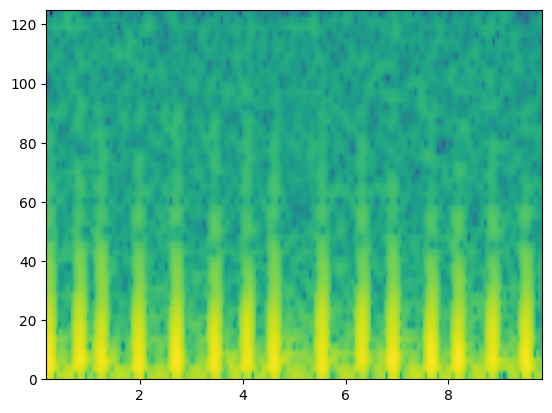

In [15]:
data_path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BaseDeDatos\\mit_bih_arrhythmiadatabase\\'
FsBaseDatosOriginal = 360 # Frecuencia de muestreo
FsBaseDatosTratada = 250 # Frecuencia de muestreo
FactorDeRemuestreo=25/36 #Factor por el que se multiplica para encontrar la parte de la señal equivalente despues del remuestreo
Fc = 0.67 # Recomendada en la bibliografia
factor = 2 # Recomendada en la bibliografia
tamano_ventana=10 # en segundos

lista_pacientes=np.array([
                 '222','222','222','222','222','222','222','222','222','222','222','222','222','222','222','222','222','222','222','222','222','222','222','222',
                 '201','201','201'
                 ])
inicio_rangos=np.array([
               363932,195781,205750,225271,250517,259507,277876,298250,304196,312335,316617,344707,348977,356580,362769,375314,378558,478549,493713,526850,575390,583789,595365,597599,
               60,171815,574742
               ])
final_rangos=np.array([
               373146,197175,206622,226476,251408,260254,279418,298720,304907,312644,317048,345059,352959,357284,363234,375783,382697,479406,494321,528571,578332,584889,596605,598541,
               136225,185067,643411
              ])

#Función quee realiza el proceso para todos los pancientes
#primer paciente
senal_ecg_canal_I_AFIB,senal_ecg_canal_II_AFIB=funcion_filtro_normalizacion_FA(lista_pacientes[0],data_path,FsBaseDatosOriginal,True)

senal_ecg_ventaneada_canal_I_AFIB=senal_ecg_canal_I_AFIB[rangos_ventaneo_senal(FsBaseDatosTratada,tamano_ventana,[int(inicio_rangos[0]*FactorDeRemuestreo),int(final_rangos[0]*FactorDeRemuestreo)])]
senal_ecg_ventaneada_canal_II_AFIB=senal_ecg_canal_II_AFIB[rangos_ventaneo_senal(FsBaseDatosTratada,tamano_ventana,[int(inicio_rangos[0]*FactorDeRemuestreo),int(final_rangos[0]*FactorDeRemuestreo)])]


#primer paciente
#primera ventana
pxx_all_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[0],FsBaseDatosTratada)
pxx_all_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[0],FsBaseDatosTratada)

#Segunda ventana
pxx_all_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[1],FsBaseDatosTratada)
pxx_all_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[1],FsBaseDatosTratada)

pxx_all_I=np.array([pxx_all_I_0,pxx_all_I_1])
pxx_all_II=np.array([pxx_all_II_0,pxx_all_II_1])

for i in np.arange(2,len(senal_ecg_ventaneada_canal_I_AFIB)):
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[i],FsBaseDatosTratada)
    pxx_all_I=np.insert(pxx_all_I,i,pxx,axis=0)
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[i],FsBaseDatosTratada)
    pxx_all_II=np.insert(pxx_all_II,i,pxx,axis=0)
    
#Todos los demás pacientes
for i in np.arange(1,len(lista_pacientes)):
    if (int(final_rangos[i]*FactorDeRemuestreo)-int(inicio_rangos[i]*FactorDeRemuestreo))<2*(tamano_ventana*FsBaseDatosTratada):
        continue
    else:
        #Extracción y filtrado de la señal
        senal_ecg_canal_I_AFIB,senal_ecg_canal_II_AFIB=funcion_filtro_normalizacion_FA(lista_pacientes[i],data_path,FsBaseDatosOriginal,True)
        
        #Ventaneo de la señal dando los parametros de frecuencia, tamaño de la ventana(en segundos), y rango de valores donde está la patología de interés
        senal_ecg_ventaneada_canal_I_AFIB=senal_ecg_canal_I_AFIB[rangos_ventaneo_senal(FsBaseDatosTratada,tamano_ventana,[int(inicio_rangos[i]*FactorDeRemuestreo),int(final_rangos[i]*FactorDeRemuestreo)])]
        senal_ecg_ventaneada_canal_II_AFIB=senal_ecg_canal_II_AFIB[rangos_ventaneo_senal(FsBaseDatosTratada,tamano_ventana,[int(inicio_rangos[i]*FactorDeRemuestreo),int(final_rangos[i]*FactorDeRemuestreo)])]
        
        #Generación de la matriz de datos del espectrograma
        #primera ventana
        pxx_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[0],FsBaseDatosTratada)
        pxx_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[0],FsBaseDatosTratada)
        
        #segunda ventana
        pxx_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[1],FsBaseDatosTratada)
        pxx_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[1],FsBaseDatosTratada)
        
        #Las demás ventanas
        pxx_I=np.array([pxx_I_0,pxx_I_1])
        pxx_II=np.array([pxx_II_0,pxx_II_1])
        
        for j in np.arange(2,len(senal_ecg_ventaneada_canal_I_AFIB)):
            pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_AFIB[j],FsBaseDatosTratada)
            pxx_I=np.insert(pxx_I,j,pxx,axis=0)
            pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_AFIB[j],FsBaseDatosTratada)
            pxx_II=np.insert(pxx_II,j,pxx,axis=0)
        #Anexando matriz generada a pxx_1
        pxx_all_I=np.insert(pxx_all_I,len(pxx_all_I),pxx_I,axis=0)
        pxx_all_II=np.insert(pxx_all_II,len(pxx_all_II),pxx_II,axis=0)

In [16]:
#Generación del array completo
pxx_all_AFIB=np.array([pxx_all_I,pxx_all_II],dtype='float64')
print(pxx_all_AFIB.shape)

(2, 121, 51, 241)


In [17]:
ruta="C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_AFIB\\"
pxx_all_AFIB=np.moveaxis(pxx_all_AFIB,0,-1)
print(pxx_all_AFIB.shape)

pxx_all_AFIB_bd=pxx_all_AFIB[:,:,:,:]
np.save(ruta+'ECG_AFIB_test.npy',pxx_all_AFIB_bd)
print(pxx_all_AFIB_bd.shape)

(121, 51, 241, 2)
(121, 51, 241, 2)


## Elevación del segmento ST:
Se realiza la extración de la señal ECG de los pacientes que presentaban elevacion del segmento ST en la base de datos MIT-BIH ST Change Database, y se realiza su filtrado, normalizado, ventaneado y se genera la matriz de 3 dimensiones de espectrogramas.

### Base de datos entrenamiento

In [18]:
#Extrayendo lista de pacientes
# manejador_archivo=open("C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BaseDeDatos\\european-st-t-database-1.0.0\\RECORDS")
# lista_pacientes_ST=[]
# for i in manejador_archivo:
#     lista_pacientes_ST.append(str(i).strip())
# print(lista_pacientes_ST)
# print(len(lista_pacientes_ST))
# manejador_archivo.close()

# # Extracción de símbolos para ver la ubicación de los segmentos de relevancia
# data_path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BaseDeDatos\\european-st-t-database-1.0.0\\'
# for i in lista_pacientes_ST:
#     grabacion_fibrilacion_auricular=wfdb.rdrecord(data_path+i)
#     anotacion_fibrilacion_auricular=wfdb.rdann(data_path+i, 'atr')
#     datos=pd.DataFrame({'Simbolo':anotacion_fibrilacion_auricular.symbol,
#                         'Nota_Aux':anotacion_fibrilacion_auricular.aux_note,
#                         'Muestra':anotacion_fibrilacion_auricular.sample})
#     pd.DataFrame(datos).to_csv("C:\\Users\\jdani\\Documents\\Prueba\\STPaciente_"+i+".csv",escapechar=',')
# datos

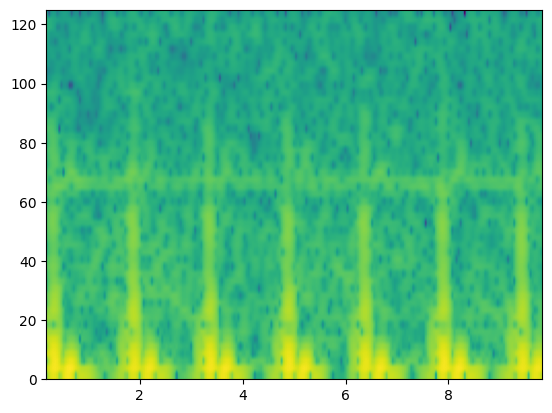

In [19]:
data_path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BaseDeDatos\\european-st-t-database-1.0.0\\'
FsBaseDatosOriginal = 250 # Frecuencia de muestreo
Fc = 0.67 # Recomendada en la bibliografia
factor = 2 # Recomendada en la bibliografia
tamano_ventana=10 # en segundos

#elevación ST
lista_pacientes_STE=np.array(['e0103','e0103','e0103','e0103','e0103','e0104','e0104','e0104','e0105','e0105','e0105','e0105','e0105','e0105','e0105','e0106','e0108','e0108','e0108','e0108','e0110','e0110','e0110','e0111','e0112','e0112','e0112','e0113','e0113','e0113','e0113','e0113','e0113','e0113','e0113','e0113','e0113','e0113','e0113','e0113',
                              'e0129','e0129','e0129','e0129'])
inicio_rangos_STE=np.array([214719,397333,575587,727684,1702273,200015,1347973,1564489,60111,393919,765755,960002,1196632,1430615,1682728,535169,674453,927187,1180901,1515847,1386853,1444351,1442131,441959,172053,300181,1542479,825159,921077,1015247,1113023,1204496,1282029,1434001,919789,1017945,1114766,1207678,1284433,1434941,
                            410277,699822,969564,1387306])
final_rangos_STE=np.array([255059,435369,613796,759225,1739121,226757,1379425,1608995,150704,515488,826474,1028791,1273751,1533116,1738620,547725,709837,964441,1202733,1526981,1394037,1460576,1459352,470486,254559,327175,1623847,835704,937119,1032558,1131521,1218373,1298361,1452968,936501,1030388,1130963,1217919,1294860,1452409,
                           465760,774899,1046734,1466885])
canal_STE=np.array([1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0])

#Función quee realiza el proceso para todos los pancientes

#PRIMER PACIENTE
senal_ecg_canal_I_STE,senal_ecg_canal_II_STE=funcion_filtro_normalizacion_FA(lista_pacientes_STE[0],data_path,FsBaseDatosOriginal,False)
senal_ecg_ventaneada_canal_I_STE=senal_ecg_canal_I_STE[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STE[0],final_rangos_STE[0]])]
#primera ventana
pxx_all_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[0],FsBaseDatosOriginal)
#segunda ventana
pxx_all_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[1],FsBaseDatosOriginal)
pxx_all=np.array([pxx_all_I_0,pxx_all_I_1])

for i in np.arange(2,len(senal_ecg_ventaneada_canal_I_STE)):
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[i],FsBaseDatosOriginal)
    pxx_all=np.insert(pxx_all,i,pxx,axis=0)
#Todos los demás pacientes
for i in np.arange(1,len(lista_pacientes_STE)):
    if canal_STE[i]==0:
        if (final_rangos_STE[i]-inicio_rangos_STE[i])<2*(tamano_ventana*FsBaseDatosOriginal):
            continue
        else:
            #Extracción y filtrado de la señal
            senal_ecg_canal_I_STE,senal_ecg_canal_II_STE=funcion_filtro_normalizacion_FA(lista_pacientes_STE[i],data_path,FsBaseDatosOriginal,False)
            senal_ecg_ventaneada_canal_I_STE=senal_ecg_canal_I_STE[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STE[i],final_rangos_STE[i]])]
            
            #Generación de la matriz de datos del espectrograma
            #primera ventana
            pxx_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[0],FsBaseDatosOriginal)
            #segunda ventana
            pxx_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[1],FsBaseDatosOriginal)
            #Las demás ventanas
            pxx_I=np.array([pxx_I_0,pxx_I_1])
            for j in np.arange(2,len(senal_ecg_ventaneada_canal_I_STE)):
                pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[j],FsBaseDatosOriginal)
                pxx_I=np.insert(pxx_I,j,pxx,axis=0)
            #Anexando matriz generada a pxx_1
            pxx_all=np.insert(pxx_all,len(pxx_all),pxx_I,axis=0)
    else:
        if (final_rangos_STE[i]-inicio_rangos_STE[i])<2*(tamano_ventana*FsBaseDatosOriginal):
            continue
        else:
            #Extracción y filtrado de la señal
            senal_ecg_canal_I_STE,senal_ecg_canal_II_STE=funcion_filtro_normalizacion_FA(lista_pacientes_STE[i],data_path,FsBaseDatosOriginal,False)
            senal_ecg_ventaneada_canal_II_STE=senal_ecg_canal_II_STE[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STE[i],final_rangos_STE[i]])]
            #Generación de la matriz de datos del espectrograma
            #primera ventana
            pxx_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_STE[0],FsBaseDatosOriginal)
            #segunda ventana
            pxx_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_STE[1],FsBaseDatosOriginal)
            #Las demás ventanas
            pxx_II=np.array([pxx_II_0,pxx_II_1])
            for j in np.arange(2,len(senal_ecg_ventaneada_canal_II_STE)):
                pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_STE[j],FsBaseDatosOriginal)
                pxx_II=np.insert(pxx_II,j,pxx,axis=0)
            #Anexando matriz generada a pxx_1
            pxx_all=np.insert(pxx_all,len(pxx_all),pxx_II,axis=0)

In [20]:
print('El tamañano generado por los datos es: '+str(pxx_all.shape))

El tamañano generado por los datos es: (1315, 51, 241)


In [21]:
print('El tamañano generado por los datos es: '+str(pxx_all.shape))

if len(pxx_all)%2!=0:
    pxx_all_I=pxx_all[:len(pxx_all)//2,:]
    print(pxx_all_I.shape)

    pxx_all_II=pxx_all[len(pxx_all)//2:len(pxx_all)-1,:]
    print(pxx_all_II.shape)
    pxx_all_STE=np.array([pxx_all_I,pxx_all_II],dtype='float64')
    print(pxx_all_STE.shape)
else:
    pxx_all_I=pxx_all[:len(pxx_all)//2,:]
    print(pxx_all_I.shape)

    pxx_all_II=pxx_all[len(pxx_all)//2:len(pxx_all),:]
    print(pxx_all_II.shape)
    pxx_all_STE=np.array([pxx_all_I,pxx_all_II],dtype='float64')
    print(pxx_all_STE.shape)

El tamañano generado por los datos es: (1315, 51, 241)
(657, 51, 241)
(657, 51, 241)
(2, 657, 51, 241)


In [22]:
ruta="C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_STE\\"

pxx_all_STE=np.moveaxis(pxx_all_STE,0,-1)
print(pxx_all_STE.shape)

#Guardando matriz original
np.save(ruta+'ECG_STE_Original.npy',pxx_all_STE)
print(pxx_all_STE.shape)

#Guardando matriz original reducida
# pxx_all_STE_bd=pxx_all_STE[:900,:,:,:]
# np.save(ruta+'ECG_STE_Original_Red.npy',pxx_all_STE_bd)
# print(pxx_all_STE_bd.shape)

(657, 51, 241, 2)
(657, 51, 241, 2)


### Base de datos test

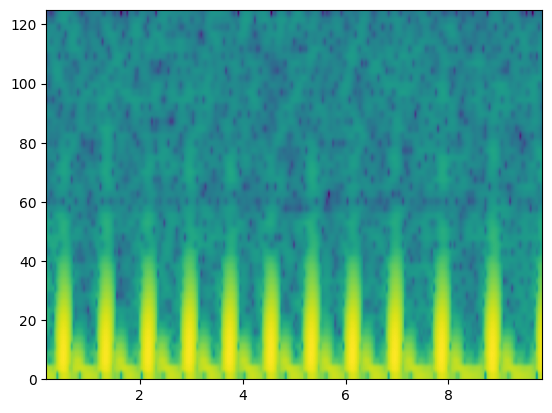

In [23]:
data_path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BaseDeDatos\\european-st-t-database-1.0.0\\'
FsBaseDatosOriginal = 250 # Frecuencia de muestreo
Fc = 0.67 # Recomendada en la bibliografia
factor = 2 # Recomendada en la bibliografia
tamano_ventana=10 # en segundos

#elevación ST
lista_pacientes_STE=np.array(['e0119','e0119','e0119','e0119','e0119',
                              'e0121',
                              'e0122',
                              'e0127','e0127','e0127','e0127'
                              ])
inicio_rangos_STE=np.array([195061,470097,1083399,1405737,1461271,
                            727570,
                            682025,
                            879300,697879,816708,1017053
                            ])
final_rangos_STE=np.array([231855,647327,1173496,1433242,1573614,
                           858499,
                           720065,
                           899319,705055,850980,1050095
                           ])
canal_STE=np.array([1,1,1,1,1,
                    1,
                    1,
                    1,0,0,0])
#Función quee realiza el proceso para todos los pancientes

#PRIMER PACIENTE
senal_ecg_canal_I_STE,senal_ecg_canal_II_STE=funcion_filtro_normalizacion_FA(lista_pacientes_STE[0],data_path,FsBaseDatosOriginal,False)
senal_ecg_ventaneada_canal_I_STE=senal_ecg_canal_I_STE[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STE[0],final_rangos_STE[0]])]
#primera ventana
pxx_all_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[0],FsBaseDatosOriginal)
#segunda ventana
pxx_all_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[1],FsBaseDatosOriginal)
pxx_all=np.array([pxx_all_I_0,pxx_all_I_1])

for i in np.arange(2,len(senal_ecg_ventaneada_canal_I_STE)):
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[i],FsBaseDatosOriginal)
    pxx_all=np.insert(pxx_all,i,pxx,axis=0)
#Todos los demás pacientes
for i in np.arange(1,len(lista_pacientes_STE)):
    if canal_STE[i]==0:
        if (final_rangos_STE[i]-inicio_rangos_STE[i])<2*(tamano_ventana*FsBaseDatosOriginal):
            continue
        else:
            #Extracción y filtrado de la señal
            senal_ecg_canal_I_STE,senal_ecg_canal_II_STE=funcion_filtro_normalizacion_FA(lista_pacientes_STE[i],data_path,FsBaseDatosOriginal,False)
            senal_ecg_ventaneada_canal_I_STE=senal_ecg_canal_I_STE[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STE[i],final_rangos_STE[i]])]
            
            #Generación de la matriz de datos del espectrograma
            #primera ventana
            pxx_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[0],FsBaseDatosOriginal)
            #segunda ventana
            pxx_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[1],FsBaseDatosOriginal)
            #Las demás ventanas
            pxx_I=np.array([pxx_I_0,pxx_I_1])
            for j in np.arange(2,len(senal_ecg_ventaneada_canal_I_STE)):
                pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_STE[j],FsBaseDatosOriginal)
                pxx_I=np.insert(pxx_I,j,pxx,axis=0)
            #Anexando matriz generada a pxx_1
            pxx_all=np.insert(pxx_all,len(pxx_all),pxx_I,axis=0)
    else:
        if (final_rangos_STE[i]-inicio_rangos_STE[i])<2*(tamano_ventana*FsBaseDatosOriginal):
            continue
        else:
            #Extracción y filtrado de la señal
            senal_ecg_canal_I_STE,senal_ecg_canal_II_STE=funcion_filtro_normalizacion_FA(lista_pacientes_STE[i],data_path,FsBaseDatosOriginal,False)
            senal_ecg_ventaneada_canal_II_STE=senal_ecg_canal_II_STE[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STE[i],final_rangos_STE[i]])]
            #Generación de la matriz de datos del espectrograma
            #primera ventana
            pxx_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_STE[0],FsBaseDatosOriginal)
            #segunda ventana
            pxx_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_STE[1],FsBaseDatosOriginal)
            #Las demás ventanas
            pxx_II=np.array([pxx_II_0,pxx_II_1])
            for j in np.arange(2,len(senal_ecg_ventaneada_canal_II_STE)):
                pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_STE[j],FsBaseDatosOriginal)
                pxx_II=np.insert(pxx_II,j,pxx,axis=0)
            #Anexando matriz generada a pxx_1
            pxx_all=np.insert(pxx_all,len(pxx_all),pxx_II,axis=0)

In [24]:
print('El tamañano generado por los datos es: '+str(pxx_all.shape))

if len(pxx_all)%2!=0:
    pxx_all_I=pxx_all[:len(pxx_all)//2,:]
    print(pxx_all_I.shape)

    pxx_all_II=pxx_all[len(pxx_all)//2:len(pxx_all)-1,:]
    print(pxx_all_II.shape)
    pxx_all_STE=np.array([pxx_all_I,pxx_all_II],dtype='float64')
    print(pxx_all_STE.shape)
else:
    pxx_all_I=pxx_all[:len(pxx_all)//2,:]
    print(pxx_all_I.shape)

    pxx_all_II=pxx_all[len(pxx_all)//2:len(pxx_all),:]
    print(pxx_all_II.shape)
    pxx_all_STE=np.array([pxx_all_I,pxx_all_II],dtype='float64')
    print(pxx_all_STE.shape)

El tamañano generado por los datos es: (550, 51, 241)
(275, 51, 241)
(275, 51, 241)
(2, 275, 51, 241)


In [25]:
ruta="C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_STE\\"

pxx_all_STE=np.moveaxis(pxx_all_STE,0,-1)
print(pxx_all_STE.shape)

#Guardando matriz de test
np.save(ruta+'ECG_STE_test.npy',pxx_all_STE)
print(pxx_all_STE.shape)

(275, 51, 241, 2)
(275, 51, 241, 2)


## Depresión del segmento ST:
Se realiza la extración de la señal ECG de los pacientes que presentaban depresión del segmento ST en la base de datos MIT-BIH ST Change Database, y se realiza su filtrado, normalizado, ventaneado y se genera la matriz de 3 dimensiones de espectrogramas.

### Base de datos entrenamiento

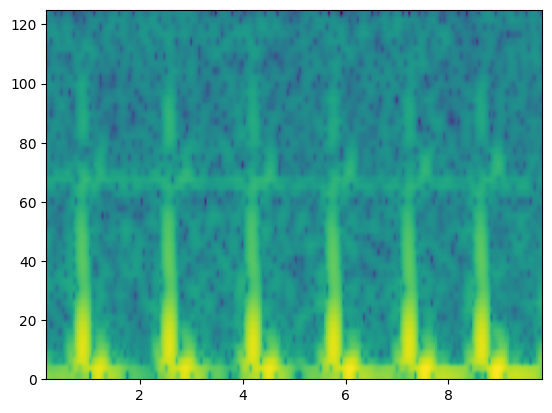

In [26]:
data_path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BaseDeDatos\\european-st-t-database-1.0.0\\'
FsBaseDatosOriginal = 250 # Frecuencia de muestreo
Fc = 0.67 # Recomendada en la bibliografia
factor = 2 # Recomendada en la bibliografia
tamano_ventana=10 # en segundos

#Depresion ST
lista_pacientes_STD=np.array(['e0104','e0104','e0104','e0105','e0105','e0105','e0105','e0106','e0106','e0106','e0106','e0106','e0106','e0106','e0107','e0107','e0108','e0108','e0108','e0108','e0108','e0111','e0112','e0112',
                              'e0113','e0113','e0113','e0113','e0113','e0113','e0113',
                              'e0115',
                              'e0116','e0116',
                              'e0118',
                              'e0129','e0129','e0129','e0129'])
inicio_rangos_STD=np.array([203027,1350587,1583947,73973,404191,806176,990709,190927,527311,692301,1039657,1196019,1446549,1623067,223835,1410119,669057,928671,1174033,1507819,1205271,427825,195083,1612245,
                           1768813,679366,826147,1275887,1401951,1527045,1658896,
                           777531,
                           202681,740889,
                           1460787,
                           403467,701555,968946,1388218
                           ])
final_rangos_STD=np.array([225473,1373737,1601553,149645,513259,826990,1022736,208311,549529,774463,1087017,1234971,1496843,1671855,295619,1512771,708301,961355,1207552,1530521,1215873,470021,251793,1621012,
                           1776538,686933,859867,1301407,1414771,1559489,1685099,
                           882991,
                           251767,779131,
                           1614495,
                           454779,755508,1031828,1438716])
canal_STD=np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,
                    1,0,0,0,0,0,0,
                    0,
                    0,0,
                    0,
                    1,1,1,1])


#Función quee realiza el proceso para todos los pancientes

#PRIMER PACIENTE
senal_ecg_canal_I_STD,senal_ecg_canal_II_STD=funcion_filtro_normalizacion_FA(lista_pacientes_STD[0],data_path,FsBaseDatosOriginal,False)
senal_ecg_ventaneada_canal_I_STD=senal_ecg_canal_I_STD[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STD[0],final_rangos_STD[0]])]
#primera ventana
pxx_all_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[0],FsBaseDatosOriginal)
#segunda ventana
pxx_all_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[1],FsBaseDatosOriginal)
pxx_all=np.array([pxx_all_I_0,pxx_all_I_1])

for i in np.arange(2,len(senal_ecg_ventaneada_canal_I_STD)):
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[i],FsBaseDatosOriginal)
    pxx_all=np.insert(pxx_all,i,pxx,axis=0)

#Todos los demás pacientes
for i in np.arange(1,len(lista_pacientes_STD)):
    if canal_STD[i]==0:
        if (final_rangos_STD[i]-inicio_rangos_STD[i])<2*(tamano_ventana*FsBaseDatosOriginal):
            continue
        else:
            #Extracción y filtrado de la señal
            senal_ecg_canal_I_STD,senal_ecg_canal_II_STD=funcion_filtro_normalizacion_FA(lista_pacientes_STD[i],data_path,FsBaseDatosOriginal,False)
            senal_ecg_ventaneada_canal_I_STD=senal_ecg_canal_I_STD[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STD[i],final_rangos_STD[i]])]
            #Generación de la matriz de datos del espectrograma
            #primera ventana
            pxx_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[0],FsBaseDatosOriginal)
            #segunda ventana
            pxx_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[1],FsBaseDatosOriginal)
            #Las demás ventanas
            pxx_I=np.array([pxx_I_0,pxx_I_1])
            for j in np.arange(2,len(senal_ecg_ventaneada_canal_I_STD)):
                pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[j],FsBaseDatosOriginal)
                pxx_I=np.insert(pxx_I,j,pxx,axis=0)
            #Anexando matriz generada a pxx_1
            pxx_all=np.insert(pxx_all,len(pxx_all),pxx_I,axis=0)
    else:
        if (final_rangos_STD[i]-inicio_rangos_STD[i])<2*(tamano_ventana*FsBaseDatosOriginal):
            continue
        else:
            #Extracción y filtrado de la señal
            senal_ecg_canal_I_STD,senal_ecg_canal_II_STD=funcion_filtro_normalizacion_FA(lista_pacientes_STD[i],data_path,FsBaseDatosOriginal,False)
            senal_ecg_ventaneada_canal_II_STD=senal_ecg_canal_II_STD[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STD[i],final_rangos_STD[i]])]
            #Generación de la matriz de datos del espectrograma
            #primera ventana
            pxx_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_STD[0],FsBaseDatosOriginal)
            #segunda ventana
            pxx_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_STD[1],FsBaseDatosOriginal)
            #Las demás ventanas
            pxx_II=np.array([pxx_II_0,pxx_II_1])
            for j in np.arange(2,len(senal_ecg_ventaneada_canal_II_STD)):
                pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_STD[j],FsBaseDatosOriginal)
                pxx_II=np.insert(pxx_II,j,pxx,axis=0)
            #Anexando matriz generada a pxx_1
            pxx_all=np.insert(pxx_all,len(pxx_all),pxx_II,axis=0)


In [27]:
print(pxx_all.shape)
#Generación del array completo
if len(pxx_all)%2!=0:
    pxx_all_I=pxx_all[:len(pxx_all)//2,:]
    print(pxx_all_I.shape)

    pxx_all_II=pxx_all[len(pxx_all)//2:len(pxx_all)-1,:]
    print(pxx_all_II.shape)
    pxx_all_STD=np.array([pxx_all_I,pxx_all_II],dtype='float64')
    print(pxx_all_STD.shape)
else:
    pxx_all_I=pxx_all[:len(pxx_all)//2,:]
    print(pxx_all_I.shape)

    pxx_all_II=pxx_all[len(pxx_all)//2:len(pxx_all),:]
    print(pxx_all_II.shape)
    pxx_all_STD=np.array([pxx_all_I,pxx_all_II],dtype='float64')
    print(pxx_all_STD.shape)

(1335, 51, 241)
(667, 51, 241)
(667, 51, 241)
(2, 667, 51, 241)


In [28]:
ruta="C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_STD\\"
pxx_all_STD=np.moveaxis(pxx_all_STD,0,-1)
print(pxx_all_STD.shape)

#Guardando matriz original
np.save(ruta+'ECG_STD_Original.npy',pxx_all_STD)
print(pxx_all_STD.shape)

#Guardando matriz original reducida
# pxx_all_STD_bd=pxx_all_STD[:900,:,:,:]
# np.save(ruta+'ECG_STD_Original_Red.npy',pxx_all_STD_bd)
# print(pxx_all_STD_bd.shape)

(667, 51, 241, 2)
(667, 51, 241, 2)


### Base de datos test

(784, 51, 241)


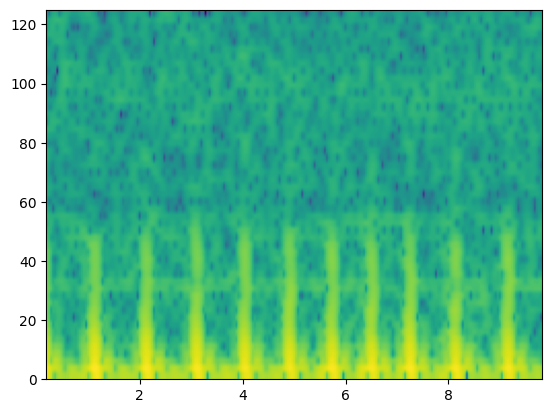

In [29]:
data_path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BaseDeDatos\\european-st-t-database-1.0.0\\'
FsBaseDatosOriginal = 250 # Frecuencia de muestreo
Fc = 0.67 # Recomendada en la bibliografia
factor = 2 # Recomendada en la bibliografia
tamano_ventana=10 # en segundos

#Depresión ST
lista_pacientes_STD=np.array(['e0119','e0119','e0121','e0122','e0123','e0123','e0123','e0211','e0211','e0127','e0127','e0127'])
inicio_rangos_STD=np.array([563572,1454934,733308,688956,989605,1082625,1185043,229329,843502,697114,817108,1021487])
final_rangos_STD=np.array([645635,1570235,853709,720691,1028917,1112645,1406119,303091,1070600,707581,837030,1052365])
canal_STD=np.array([0,0,0,0,0,0,0,0,0,1,1,1])


#Función quee realiza el proceso para todos los pancientes

#PRIMER PACIENTE
senal_ecg_canal_I_STD,senal_ecg_canal_II_STD=funcion_filtro_normalizacion_FA(lista_pacientes_STD[0],data_path,FsBaseDatosOriginal,False)
senal_ecg_ventaneada_canal_I_STD=senal_ecg_canal_I_STD[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STD[0],final_rangos_STD[0]])]
#primera ventana
pxx_all_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[0],FsBaseDatosOriginal)
#segunda ventana
pxx_all_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[1],FsBaseDatosOriginal)
pxx_all=np.array([pxx_all_I_0,pxx_all_I_1])

for i in np.arange(2,len(senal_ecg_ventaneada_canal_I_STD)):
    pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[i],FsBaseDatosOriginal)
    pxx_all=np.insert(pxx_all,i,pxx,axis=0)

#Todos los demás pacientes
for i in np.arange(1,len(lista_pacientes_STD)):
    if canal_STD[i]==0:
        if (final_rangos_STD[i]-inicio_rangos_STD[i])<2*(tamano_ventana*FsBaseDatosOriginal):
            continue
        else:
            #Extracción y filtrado de la señal
            senal_ecg_canal_I_STD,senal_ecg_canal_II_STD=funcion_filtro_normalizacion_FA(lista_pacientes_STD[i],data_path,FsBaseDatosOriginal,False)
            senal_ecg_ventaneada_canal_I_STD=senal_ecg_canal_I_STD[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STD[i],final_rangos_STD[i]])]
            #Generación de la matriz de datos del espectrograma
            #primera ventana
            pxx_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[0],FsBaseDatosOriginal)
            #segunda ventana
            pxx_I_1=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[1],FsBaseDatosOriginal)
            #Las demás ventanas
            pxx_I=np.array([pxx_I_0,pxx_I_1])
            for j in np.arange(2,len(senal_ecg_ventaneada_canal_I_STD)):
                pxx=graph_spectrogram(senal_ecg_ventaneada_canal_I_STD[j],FsBaseDatosOriginal)
                pxx_I=np.insert(pxx_I,j,pxx,axis=0)
            #Anexando matriz generada a pxx_1
            pxx_all=np.insert(pxx_all,len(pxx_all),pxx_I,axis=0)
    else:
        if (final_rangos_STD[i]-inicio_rangos_STD[i])<2*(tamano_ventana*FsBaseDatosOriginal):
            continue
        else:
            #Extracción y filtrado de la señal
            senal_ecg_canal_I_STD,senal_ecg_canal_II_STD=funcion_filtro_normalizacion_FA(lista_pacientes_STD[i],data_path,FsBaseDatosOriginal,False)
            senal_ecg_ventaneada_canal_II_STD=senal_ecg_canal_II_STD[rangos_ventaneo_senal(FsBaseDatosOriginal,tamano_ventana,[inicio_rangos_STD[i],final_rangos_STD[i]])]
            #Generación de la matriz de datos del espectrograma
            #primera ventana
            pxx_II_0=graph_spectrogram(senal_ecg_ventaneada_canal_II_STD[0],FsBaseDatosOriginal)
            #segunda ventana
            pxx_II_1=graph_spectrogram(senal_ecg_ventaneada_canal_II_STD[1],FsBaseDatosOriginal)
            #Las demás ventanas
            pxx_II=np.array([pxx_II_0,pxx_II_1])
            for j in np.arange(2,len(senal_ecg_ventaneada_canal_II_STD)):
                pxx=graph_spectrogram(senal_ecg_ventaneada_canal_II_STD[j],FsBaseDatosOriginal)
                pxx_II=np.insert(pxx_II,j,pxx,axis=0)
            #Anexando matriz generada a pxx_1
            pxx_all=np.insert(pxx_all,len(pxx_all),pxx_II,axis=0)
print(pxx_all.shape)

In [30]:
if len(pxx_all)%2!=0:
    pxx_all_I=pxx_all[:len(pxx_all)//2,:]
    print(pxx_all_I.shape)

    pxx_all_II=pxx_all[len(pxx_all)//2:len(pxx_all)-1,:]
    print(pxx_all_II.shape)
    pxx_all_STD=np.array([pxx_all_I,pxx_all_II],dtype='float64')
    print(pxx_all_STD.shape)
else:
    pxx_all_I=pxx_all[:len(pxx_all)//2,:]
    print(pxx_all_I.shape)

    pxx_all_II=pxx_all[len(pxx_all)//2:len(pxx_all),:]
    print(pxx_all_II.shape)
    pxx_all_STD=np.array([pxx_all_I,pxx_all_II],dtype='float64')
    print(pxx_all_STD.shape)

(392, 51, 241)
(392, 51, 241)
(2, 392, 51, 241)


In [31]:
ruta="C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_STD\\"
pxx_all_STD=np.moveaxis(pxx_all_STD,0,-1)
print(pxx_all_STD.shape)

#Guardando matriz original
np.save(ruta+'ECG_STD_test.npy',pxx_all_STD)
print(pxx_all_STD.shape)

(392, 51, 241, 2)
(392, 51, 241, 2)
